In [1]:
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime

yf.pdr_override()

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show the data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500196,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567370,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706894,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839728,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819365,394024400


In [2]:
df.shape

(2805, 6)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2805 entries, 2012-01-03 to 2023-02-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2805 non-null   float64
 1   High       2805 non-null   float64
 2   Low        2805 non-null   float64
 3   Close      2805 non-null   float64
 4   Adj Close  2805 non-null   float64
 5   Volume     2805 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 153.4 KB


In [4]:
df1 = df.iloc[:,1]
df1.head()

Date
2012-01-03    14.732143
2012-01-04    14.810000
2012-01-05    14.948214
2012-01-06    15.098214
2012-01-09    15.276786
Name: High, dtype: float64

In [5]:
df1.tail()

Date
2023-02-17    153.000000
2023-02-21    151.300003
2023-02-22    149.949997
2023-02-23    150.339996
2023-02-24    147.190002
Name: High, dtype: float64

In [6]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

Date
2012-01-03    14.732143
2012-01-04    14.810000
2012-01-05    14.948214
2012-01-06    15.098214
2012-01-09    15.276786
Name: High, dtype: float64

Text(0, 0.5, 'stock price')

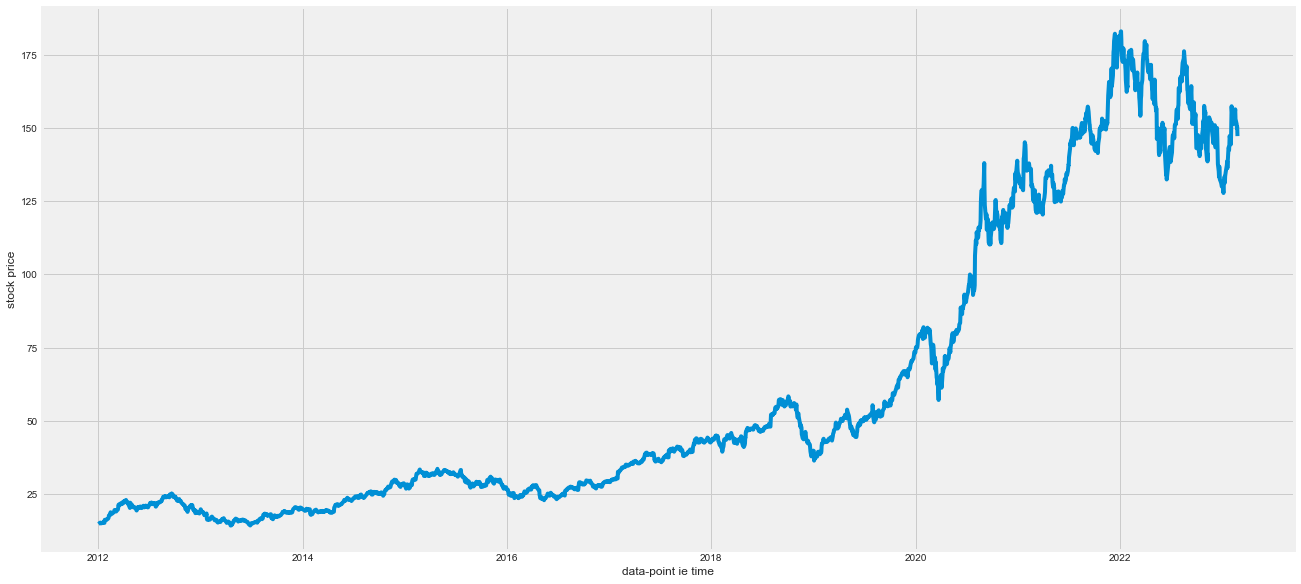

In [7]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

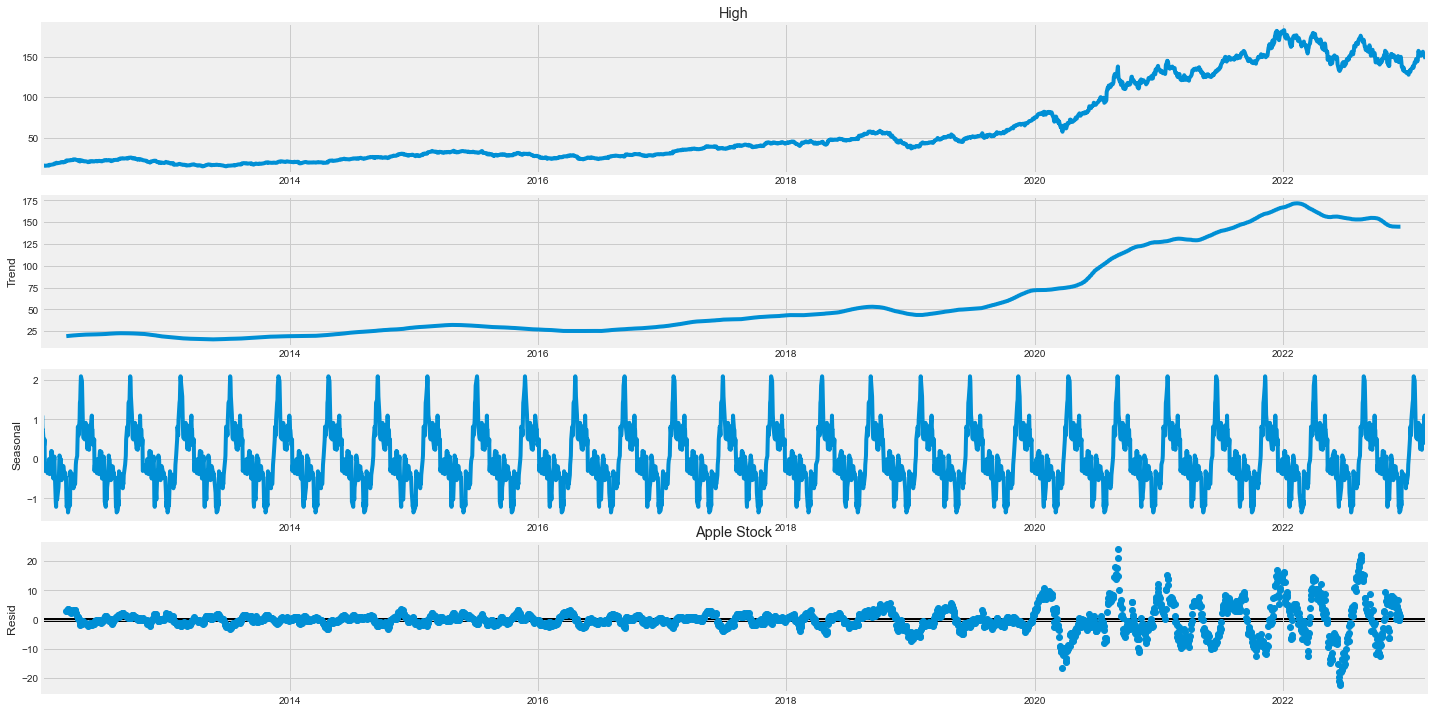

In [8]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [10]:
df1.shape

(2805,)

In [11]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[0.00273148]
 [0.00319307]
 [0.00401251]
 ...
 [0.80440929]
 [0.80672152]
 [0.78804587]]

 df1 present shape :  (2805, 1)


### splitting data (70/30)

In [13]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  1963
Test Size :  842


In [14]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (1963, 1)
Test Data Shape:  (842, 1)


### | windowing data set |

In [15]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [16]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1862, 100) (1862,)
(741, 100) (741,)


In [18]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 52,101
Trainable params: 52,101
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [22]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 100, batch_size=64,verbose=1)

Epoch 1/100
30/30 [==============================] - 15s 278ms/step - loss: 0.0020 - val_loss: 0.0083
Epoch 2/100
30/30 [==============================] - 6s 206ms/step - loss: 1.2941e-04 - val_loss: 0.0027
Epoch 3/100
30/30 [==============================] - 6s 208ms/step - loss: 9.3248e-05 - val_loss: 0.0025
Epoch 4/100
30/30 [==============================] - 6s 207ms/step - loss: 7.8153e-05 - val_loss: 0.0039
Epoch 5/100
30/30 [==============================] - 6s 202ms/step - loss: 7.6918e-05 - val_loss: 0.0029
Epoch 6/100
30/30 [==============================] - 6s 201ms/step - loss: 7.1345e-05 - val_loss: 0.0056
Epoch 7/100
30/30 [==============================] - 6s 201ms/step - loss: 6.9270e-05 - val_loss: 0.0083
Epoch 8/100
30/30 [==============================] - 6s 200ms/step - loss: 6.4100e-05 - val_loss: 0.0085
Epoch 9/100
30/30 [==============================] - 6s 204ms/step - loss: 6.1579e-05 - val_loss: 0.0080
Epoch 10/100
30/30 [==============================] - 6s 2

30/30 [==============================] - 6s 205ms/step - loss: 2.3196e-05 - val_loss: 0.0020
Epoch 79/100
30/30 [==============================] - 6s 197ms/step - loss: 1.9646e-05 - val_loss: 0.0054
Epoch 80/100
30/30 [==============================] - 6s 214ms/step - loss: 2.2940e-05 - val_loss: 0.0035
Epoch 81/100
30/30 [==============================] - 6s 208ms/step - loss: 1.5970e-05 - val_loss: 0.0014
Epoch 82/100
30/30 [==============================] - 6s 204ms/step - loss: 2.1081e-05 - val_loss: 0.0033
Epoch 83/100
30/30 [==============================] - 6s 206ms/step - loss: 1.4324e-05 - val_loss: 0.0037
Epoch 84/100
30/30 [==============================] - 6s 202ms/step - loss: 1.4058e-05 - val_loss: 0.0013
Epoch 85/100
30/30 [==============================] - 6s 200ms/step - loss: 1.4579e-05 - val_loss: 0.0021
Epoch 86/100
30/30 [==============================] - 7s 222ms/step - loss: 1.3728e-05 - val_loss: 0.0020
Epoch 87/100
30/30 [==============================] - 6s 20

In [23]:
y_pred = scaler.inverse_transform(model.predict(X_test))

24/24 [==============================] - 2s 39ms/step


In [24]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
y_pred[:5]

array([[64.30676 ],
       [62.429707],
       [60.724216],
       [60.58394 ],
       [60.851246]], dtype=float32)

In [26]:
y_test[:5]

array([[64.40249634],
       [62.5       ],
       [63.20999908],
       [62.95750046],
       [57.125     ]])

### evaluation

In [27]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  11.16977813762451


In [28]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.8346130134407675


### visualization + plotting

59/59 [==============================] - 2s 38ms/step


No handles with labels found to put in legend.


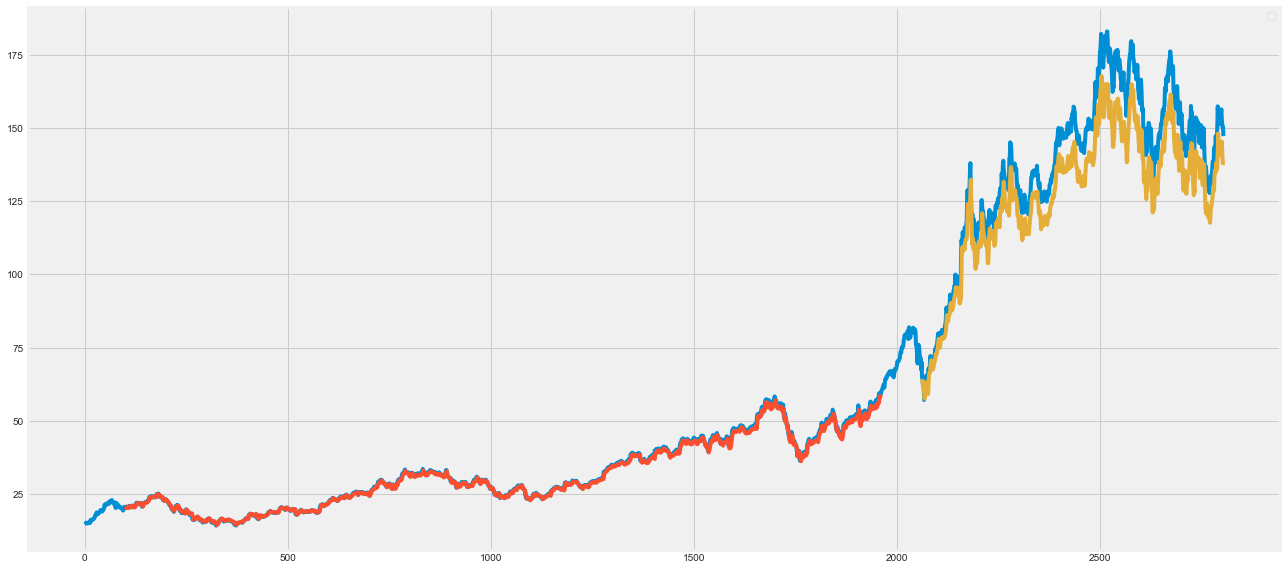

In [29]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [30]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [32]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [33]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [34]:
print(scaler.inverse_transform(lst_output))

[[135.14265658]
 [123.90991858]
 [110.85810282]
 [ 97.38030312]
 [ 84.22614345]
 [ 71.95641421]
 [ 60.93335558]
 [ 51.33175399]
 [ 43.17133426]
 [ 36.35987378]
 [ 30.73853964]
 [ 26.12168269]
 [ 22.32643731]
 [ 19.190915  ]
 [ 16.58258641]
 [ 14.39938889]
 [ 12.56650801]
 [ 11.03084338]
 [  9.75499269]
 [  8.71163951]
 [  7.87905776]
 [  7.23782861]
 [  6.76891965]
 [  6.45270722]
 [  6.26891543]
 [  6.19699193]
 [  6.21678462]
 [  6.3092567 ]
 [  6.45712067]
 [  6.6452945 ]]


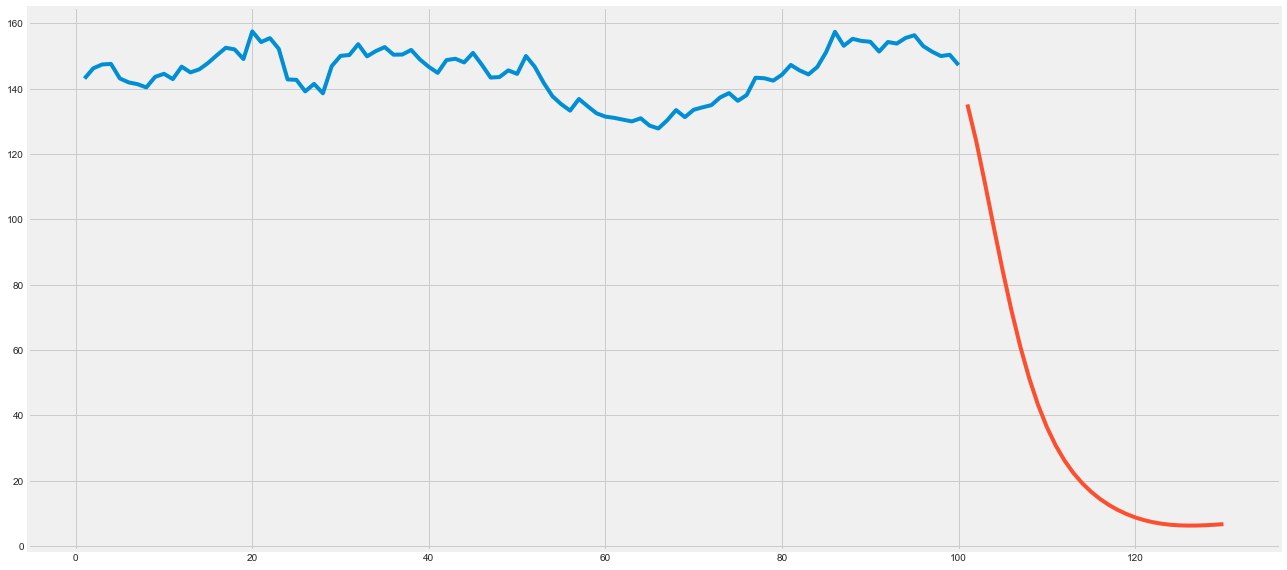

In [35]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))